In [ ]:
#Загрузка файла с табличными данными
!wget https://www.dropbox.com/s/2yjaru8mbkeynwe/dataset%20%283%29.csv?dl=1 -O dataset.csv

In [73]:
#Импортирование необходимых библиотек для обработки и чтение файла с табличными данными
import cv2
import os
import numpy as np
import shutil
import torch
import zipfile
import cv2
import os
import numpy as np
import pandas as pd
import datetime as dt
dataset = pd.read_csv('dataset_prefin.csv')
dataset_temp = pd.read_csv('dataset.csv')

In [74]:
dataset['video_popularity'] = dataset_temp['pop_score']
dataset['video_duration'] = dataset_temp['video_duration']

In [ ]:
preds = []
import torchvision.models
import torchvision.transforms as transforms
model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(in_features=2048, out_features=1)
model = model.cuda()
device = 'cuda'
model.load_state_dict(torch.load('model-resnet50.pth', map_location=device))
transform_train_img = transforms.Compose([transforms.Resize([224, 224]),
transforms.ToTensor()])
from PIL import Image
preds = []
model.eval().cuda()
i = 0
for image in dataset['review']:
    i+=1
    print(i)
    image = Image.open(os.path.join('images-2/images-2', image))
    image = transform_train_img(image)
    image = image.unsqueeze(0)
    image = image.cuda()
    with torch.no_grad():
        score = model(image)
        preds.append(score)
for i in range(len(preds)):
    preds[i] = preds[i].item()
dataset['pop_score'] = preds

In [75]:
dataset = dataset.rename(columns={"view_count": "view_count_prev", "like_count": "like_count_prev", "dislike_count":"dislike_count_prev", "comment_count":"comment_count_prev" })

In [76]:
#Обработка временных показателей даты загрузки видео на видеохостинг и даты создания канала.
dataset['Time_cur'] = pd.to_datetime(dataset['published_at'])
dataset['published_hour_cur'] = dataset['Time_cur'].dt.hour
dataset['Weekday_cur'] = dataset['Time_cur'].dt.weekday
diff = dt.datetime.now() - dataset['Time_cur']
dataset['Published_diff_time'] = (dt.datetime.now() - dataset['Time_cur']).dt.total_seconds()
dataset  = dataset.drop(['Time_cur', 'published_at'], axis=1)
dataset['channel_founded'] = pd.to_datetime(dataset['channel_founded'])
diff = dt.datetime.now() - dataset['channel_founded']
dataset['channel_founded'] = diff.dt.total_seconds()

In [77]:
# Деление видео на классы популярных и непопулярных

In [78]:
# Обработка категориальных признаков(день недели и час публикации видео) при помощи one hot encoder.
from sklearn.preprocessing import OneHotEncoder
dataset = pd.get_dummies(dataset, columns=['published_hour_cur', 'Weekday_cur'], prefix=["published_hour", "Weekday_cur"] )

In [ ]:
import re
for i in range(len(dataset['video_duration'])):
    tmp = ''
    if 'H' not in dataset['video_duration'][i]:
        tmp += '0H'
    else:
        tmp += re.findall(r"(\d+)H", dataset['video_duration'][i])[0] + 'H'
    if 'M' not in dataset['video_duration'][i]:
        tmp += '0M'
    else:
        tmp += re.findall(r"(\d+)M", dataset['video_duration'][i])[0] + 'M'
    if 'S' not in dataset['video_duration'][i]:
        tmp += '0S'
    else:
        tmp += re.findall(r"(\d+)S", dataset['video_duration'][i])[0] + 'S'
    tmp = re.findall(r'\d+', tmp)
    numbers = [int(x) for x in tmp]
    seconds = 0
    seconds += numbers[0] * 3600
    seconds += numbers[1] * 60
    seconds += numbers[2]
    dataset['video_duration'][i] = seconds

In [79]:
# Приминение нормализации к вещественным признакам, которые используются для классификации видео.
from sklearn.preprocessing import StandardScaler
dataset_norm = dataset[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev', 'dislike_count_prev', 'favorite_count', 'comment_count_prev',  'Published_diff_time' ]]
dataset_norm  = dataset_norm.values
scaler = StandardScaler()
dataset_norm = scaler.fit_transform(dataset_norm)
dataset[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev', 'dislike_count_prev', 'favorite_count', 'comment_count_prev',  'Published_diff_time']] = dataset_norm 







In [80]:
#Разбиение набора данных на обучающую, валидационную и тестовую выборку по времени публикации видео.

In [81]:
dataset['popular'] = 0.0
dataset['popular'][dataset.view_count_new.gt(dataset.view_count_new.quantile(0.8))] = 1.0

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
train_ids = int(0.8*len(dataset))
val_ids = int(0.8*len(dataset)) + int(0.1*len(dataset))
train = dataset[:train_ids]
val = dataset[train_ids:val_ids]
test = dataset[val_ids:len(dataset)]

# Подготовка данных

In [83]:
train_numerical = train[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time']].values
train_categorical = train[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values

train_target = train[['popular']].values

In [84]:
val_numerical = val[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time']].values
val_categorical = val[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
val_target = val[['popular']].values

In [85]:
test_numerical = test[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time']].values
test_categorical = test[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
test_target = test[['popular']].values

In [ ]:
pip install transformers

In [114]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [115]:
input_ids = []
attention_masks = []
for elem in dataset['video_title']:
    encoded_dict = tokenizer.encode_plus(
                        elem,                      
                        add_special_tokens = True, 
                        max_length = 10,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [116]:
model = BertModel.from_pretrained('bert-base-uncased')

In [117]:
hiddens = model(input_ids, attention_masks)[0]

In [118]:
hiddens[0].shape

torch.Size([10, 768])

In [119]:
encodings = []

In [120]:
for i in range(hiddens.shape[0]):
    encodings.append(hiddens[i].mean(axis = 0).cpu().detach().numpy())

In [121]:
encodings[0].shape

(768,)

In [122]:
encoding = np.array(encodings)

In [123]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)

In [124]:
text = pca.fit_transform(encoding)

In [125]:
train_text = text[0:train_ids]

In [126]:
val_text = text[train_ids:val_ids]

In [127]:
text_test = text[val_ids:len(dataset)]

# XGBoost with numerical and categorical data

In [100]:
train_boost = [train_numerical, train_categorical]
train_boost = np.concatenate(train_boost, axis = 1)
val_boost = [val_numerical, val_categorical]
val_boost = np.concatenate(val_boost, axis = 1)
test_boost = [test_numerical, test_categorical]
test_boost = np.concatenate(test_boost, axis = 1)

In [101]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def binary_acc(y_pred, y_test, thresh):
    y_pred_tag = (y_pred>thresh).astype(int)
    correct_results_sum = (y_pred_tag == y_test.squeeze()).sum()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc.item()
    return acc

max_depths = [1, 2, 3, 4, 5, 6, 7]
n_estimators = [70, 80, 190, 200]
lrs = [0.01, 0.02, 0.05, 0.07, 0.1]
subsample = [0.5, 0.6, 0.7, 1]
min_child_weight = [1, 3, 6, 7, 8, 9]

val_metrics = []
test_metrics = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for l in lrs:
            for subsampl in subsample:
                for min_chil in min_child_weight:
                    clf = XGBClassifier( objective= 'binary:logistic',max_depth = max_depth, n_estimators = n_estimator,learning_rate = l, subsample = subsampl, min_child = min_chil, nthread= 24, seed=24, verbose = 1)
                    print(clf)
                    clf.fit(train_boost, train_target.ravel())
                    res = clf.predict_proba(val_boost)
                    acc = binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5)
                    prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    val_metrics.append((acc, prec, rec, roc_auc))
                    res = clf.predict_proba(test_boost)
                    acc = binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5)
                    prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    test_metrics.append((acc, prec, rec, roc_auc))
            


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=1, min_child=1,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=24, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              silent=None, subsample=0.5, verbose=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=1, min_child=3,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=24, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              silent=None, subsample=0.5, verbose=1, verbosity=1)
XGBClassifier(ba

In [102]:
test_metrics = [list(elem) for elem in test_metrics]
val_metrics = [list(elem) for elem in val_metrics]
print(max(test_metrics,key=lambda item:item[3]))
combs = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for l in lrs:
            for subsampl in subsample:
                for min_chil in min_child_weight:
                    combs.append([max_depth, n_estimator, l, subsampl, min_chil])
val_metrics = pd.DataFrame.from_records(val_metrics, columns = ['acc_val', 'prec_val', 'rec_val',  'roc_auc_val'])
test_metrics = pd.DataFrame.from_records(test_metrics, columns = ['acc_test', 'prec_test', 'rec_test',  'roc_auc_test'])
combs = pd.DataFrame.from_records(combs, columns = ['max_depth', 'n_estimators', 'learning_rate', 'subsample', 'min_child_weight'])
xgboost_metrics = pd.concat([combs, val_metrics, test_metrics], axis=1, sort=False)
xgboost_metrics.to_csv('xgboost_metrics_numerical_categorical.csv', index=False)



[0.8696911196911197, 0.6136363636363636, 0.4909090909090909, 0.7161778519987476]


In [109]:
xgboost_metrics.sort_values(['roc_auc_test'], ascending = False)

max_depth  n_estimators  learning_rate  subsample  min_child_weight  \
3096          7            80            0.1        0.5                 1   
3097          7            80            0.1        0.5                 3   
3098          7            80            0.1        0.5                 6   
3099          7            80            0.1        0.5                 7   
3100          7            80            0.1        0.5                 8   
...         ...           ...            ...        ...               ...   
3110          7            80            0.1        0.7                 6   
3113          7            80            0.1        0.7                 9   
3112          7            80            0.1        0.7                 8   
3111          7            80            0.1        0.7                 7   
3108          7            80            0.1        0.7                 1   

       acc_val  prec_val   rec_val  roc_auc_val  acc_test  prec_test  \
3096  0.818182  0.619512  0.535865     0.718999  0.869691   0.613636   
3097  0.818182  0.619512  0.535865     0.718999  0.869691   0.613636   
3098  0.818182  0.619512  0.535865     0.718999  0.869691   0.613636   
3099  0.818182  0.619512  0.535865     0.718999  0.869691   0.613636   
3100  0.818182  0.619512  0.535865     0.718999  0.869691   0.613636   
...        ...       ...       ...          ...       ...        ...   
3110  0.808511  0.596059  0.510549     0.703831  0.857143   0.577982   
3113  0.808511  0.596059  0.510549     0.703831  0.857143   0.577982   
3112  0.808511  0.596059  0.510549     0.703831  0.857143   0.577982   
3111  0.808511  0.596059  0.510549     0.703831  0.857143   0.577982   
3108  0.808511  0.596059  0.510549     0.703831  0.857143   0.577982   

      rec_test  roc_auc_test  
3096  0.490909      0.716178  
3097  0.490909      0.716178  
3098  0.490909      0.716178  
3099  0.490909      0.716178  
3100  0.490909      0.716178  
...        ...           ...  
3110  0.381818      0.664503  
3113  0.381818      0.664503  
3112  0.381818      0.664503  
3111  0.381818      0.664503  
3108  0.381818      0.664503  

[3360 rows x 13 columns]

In [110]:
clf = XGBClassifier( objective= 'binary:logistic',max_depth = 7, n_estimators = 80,learning_rate = 0.1, subsample = 0.5, min_child = 1, nthread= 24, seed=24, verbose = 1)

In [111]:
clf.fit(train_boost, train_target.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7, min_child=1,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=24, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              silent=None, subsample=0.5, verbose=1, verbosity=1)

In [ ]:
#Best parameters

# Text,  numerical and categorical

In [129]:
train_boost = [train_numerical, train_categorical, train_text]
train_boost = np.concatenate(train_boost, axis = 1)
val_boost = [val_numerical, val_categorical, val_text]
val_boost = np.concatenate(val_boost, axis = 1)
test_boost = [test_numerical, test_categorical, text_test]
test_boost = np.concatenate(test_boost, axis = 1)

In [130]:
train_text

array([[ 5.245058  , -0.7061929 ,  1.7506249 , ..., -0.0180368 ,
         0.5922782 ,  0.21643105],
       [ 5.245052  , -0.70614284,  1.7506046 , ..., -0.01802612,
         0.59228253,  0.21648623],
       [ 4.677395  , -1.9168677 ,  3.2896755 , ...,  0.19569549,
         0.13121861,  0.5416131 ],
       ...,
       [-0.1171528 , -1.5277196 , -1.7381827 , ..., -0.9074673 ,
        -0.16749609, -1.6354078 ],
       [ 0.05100567,  1.0604378 , -0.09733788, ...,  0.23428546,
        -0.12355898, -0.5840994 ],
       [ 0.6446641 , -0.83442193, -2.1485984 , ..., -0.7457718 ,
        -0.24743646, -1.1692965 ]], dtype=float32)

In [131]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
def binary_acc(y_pred, y_test, thresh):
    y_pred_tag = (y_pred>thresh).astype(int)
    correct_results_sum = (y_pred_tag == y_test.squeeze()).sum()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc.item()
    return acc

max_depths = [1, 2, 3, 4, 5, 6, 7]
n_estimators = [70, 80, 190, 200]
lrs = [0.01, 0.02, 0.05, 0.07, 0.1]
subsample = [0.5, 0.6, 0.7, 1]
min_child_weight = [1, 3, 6, 7, 8, 9]

val_metrics = []
test_metrics = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for l in lrs:
            for subsampl in subsample:
                for min_chil in min_child_weight:
                    clf = XGBClassifier( objective= 'binary:logistic',max_depth = max_depth, n_estimators = n_estimator,learning_rate = l, subsample = subsampl, min_child = min_chil, nthread= 24, seed=24, verbose = 1)
                    print(clf)
                    clf.fit(train_boost, train_target.ravel())
                    res = clf.predict_proba(val_boost)
                    acc = binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5)
                    prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    val_metrics.append((acc, prec, rec, roc_auc))
                    res = clf.predict_proba(test_boost)
                    acc = binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5)
                    prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    test_metrics.append((acc, prec, rec, roc_auc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=1, min_child=1,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=24, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              silent=None, subsample=0.5, verbose=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=1, min_child=3,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=24, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              silent=None, subsample=0.5, verbose=1, verbosity=1)
XGBClassifier(ba

In [132]:
test_metrics = [list(elem) for elem in test_metrics]
val_metrics = [list(elem) for elem in val_metrics]
print(max(val_metrics,key=lambda item:item[0]))

[0.8336557059961315, 0.6666666666666666, 0.5485232067510548, 0.733483686186067]


In [133]:
val_metrics = [list(elem) for elem in val_metrics]

In [134]:
max(val_metrics,key=lambda item:item[0])

[0.8336557059961315, 0.6666666666666666, 0.5485232067510548, 0.733483686186067]

In [135]:
combs = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for l in lrs:
            for subsampl in subsample:
                for min_chil in min_child_weight:
                    combs.append([max_depth, n_estimator, l, subsampl, min_chil])

In [136]:
val_metrics = pd.DataFrame.from_records(val_metrics, columns = ['acc_val', 'prec_val', 'rec_val',  'roc_auc_val'])
test_metrics = pd.DataFrame.from_records(test_metrics, columns = ['acc_test', 'prec_test', 'rec_test',  'roc_auc_test'])
combs = pd.DataFrame.from_records(combs, columns = ['max_depth', 'n_estimators', 'learning_rate', 'subsample', 'min_child_weight'])
xgboost_metrics = pd.concat([combs, val_metrics, test_metrics], axis=1, sort=False)
xgboost_metrics.to_csv('xgboost_metrics_text.csv', index=False)

In [137]:
xgboost_metrics.to_csv('xgboost_metrics_text.csv', index=False)

In [138]:
xgboost_metrics.sort_values(by = 'roc_auc_test',   ascending=False)

max_depth  n_estimators  learning_rate  subsample  min_child_weight  \
2935          7            70           0.05        0.6                 3   
2934          7            70           0.05        0.6                 1   
2936          7            70           0.05        0.6                 6   
2937          7            70           0.05        0.6                 7   
2938          7            70           0.05        0.6                 8   
...         ...           ...            ...        ...               ...   
2857          6           200           0.10        0.5                 3   
2859          6           200           0.10        0.5                 7   
2860          6           200           0.10        0.5                 8   
2861          6           200           0.10        0.5                 9   
2856          6           200           0.10        0.5                 1   

       acc_val  prec_val   rec_val  roc_auc_val  acc_test  prec_test  \
2935  0.826886  0.646465  0.540084     0.726128  0.876448   0.645669   
2934  0.826886  0.646465  0.540084     0.726128  0.876448   0.645669   
2936  0.826886  0.646465  0.540084     0.726128  0.876448   0.645669   
2937  0.826886  0.646465  0.540084     0.726128  0.876448   0.645669   
2938  0.826886  0.646465  0.540084     0.726128  0.876448   0.645669   
...        ...       ...       ...          ...       ...        ...   
2857  0.815280  0.618557  0.506329     0.706740  0.850386   0.543103   
2859  0.815280  0.618557  0.506329     0.706740  0.850386   0.543103   
2860  0.815280  0.618557  0.506329     0.706740  0.850386   0.543103   
2861  0.815280  0.618557  0.506329     0.706740  0.850386   0.543103   
2856  0.815280  0.618557  0.506329     0.706740  0.850386   0.543103   

      rec_test  roc_auc_test  
2935  0.496970      0.722652  
2934  0.496970      0.722652  
2936  0.496970      0.722652  
2937  0.496970      0.722652  
2938  0.496970      0.722652  
...        ...           ...  
2857  0.381818      0.660484  
2859  0.381818      0.660484  
2860  0.381818      0.660484  
2861  0.381818      0.660484  
2856  0.381818      0.660484  

[3360 rows x 13 columns]

In [ ]:
!pip install xgboost

In [ ]:
clf = XGBClassifier( objective= 'binary:logistic',max_depth = 6, n_estimators = 80,learning_rate = 0.07, subsample = 0.5, min_child = 7, nthread= 24, seed=24, verbose = 1)

In [ ]:
clf.fit(train_boost, train_target.ravel())

In [ ]:
clf.fit(train_boost, train_target.ravel())
feature_importance = clf.feature_importances_
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos, np.array(columns)[sorted_idx][-10:])
plt.title('Feature Importance')

result = permutation_importance(clf, val_boost, val_target, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
train_boost.shape

In [ ]:
val_numerical = val[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_cur_time']].values
val_categorical = val[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values


In [ ]:
columns = ['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_cur_time', 'published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']

In [ ]:
for i in range(train_text.shape[1]):
    columns.append('text_' + str(i))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos, np.array(columns)[sorted_idx][-10:])
plt.title('Feature Importance')

result = permutation_importance(clf, val_boost, val_target, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Visual features + text features + numerical and categorical features

In [139]:
train_numerical = train[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity']].values
train_categorical = train[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
train_target = train[['popular']].values

In [140]:
val_numerical = val[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity']].values
val_categorical = val[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
val_target = val[['popular']].values

In [141]:
test_numerical = test[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity']].values
test_categorical = test[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
test_target = test[['popular']].values

In [142]:
train_boost = [train_numerical, train_categorical, train_text]
train_boost = np.concatenate(train_boost, axis = 1)
val_boost = [val_numerical, val_categorical, val_text]
val_boost = np.concatenate(val_boost, axis = 1)
test_boost = [test_numerical, test_categorical, text_test]
test_boost = np.concatenate(test_boost, axis = 1)

In [143]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
def binary_acc(y_pred, y_test, thresh):
    y_pred_tag = (y_pred>thresh).astype(int)
    correct_results_sum = (y_pred_tag == y_test.squeeze()).sum()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc.item()
    return acc

max_depths = [1, 2, 3, 4, 5, 6, 7]
n_estimators = [70, 80, 190, 200]
lrs = [0.01, 0.02, 0.05, 0.07, 0.1]
subsample = [0.5, 0.6, 0.7, 1]
min_child_weight = [1, 3, 6, 7, 8, 9]

val_metrics = []
test_metrics = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for l in lrs:
            for subsampl in subsample:
                for min_chil in min_child_weight:
                    clf = XGBClassifier( objective= 'binary:logistic',max_depth = max_depth, n_estimators = n_estimator,learning_rate = l, subsample = subsampl, min_child = min_chil, nthread= 24, seed=24, verbose = 1)
                    print(clf)
                    clf.fit(train_boost, train_target.ravel())
                    res = clf.predict_proba(val_boost)
                    acc = binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5)
                    prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))
                    val_metrics.append((acc, prec, rec, roc_auc))
                    res = clf.predict_proba(test_boost)
                    acc = binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5)
                    prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))
                    test_metrics.append((acc, prec, rec, roc_auc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=1, min_child=1,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=24, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              silent=None, subsample=0.5, verbose=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=1, min_child=3,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=24, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              silent=None, subsample=0.5, verbose=1, verbosity=1)
XGBClassifier(ba

In [144]:
test_metrics = [list(elem) for elem in test_metrics]
val_metrics = [list(elem) for elem in val_metrics]
max(val_metrics,key=lambda item:item[3])

[0.8433268858800773,
 0.6728110599078341,
 0.6160337552742616,
 0.7634748450147971]

In [145]:
combs = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for l in lrs:
            for subsampl in subsample:
                for min_chil in min_child_weight:
                    combs.append([max_depth, n_estimator, l, subsampl, min_chil])

In [146]:
val_metrics = pd.DataFrame.from_records(val_metrics, columns = ['acc_val', 'prec_val', 'rec_val',  'roc_auc_val'])
test_metrics = pd.DataFrame.from_records(test_metrics, columns = ['acc_test', 'prec_test', 'rec_test',  'roc_auc_test'])
combs = pd.DataFrame.from_records(combs, columns = ['max_depth', 'n_estimators', 'learning_rate', 'subsample', 'min_child_weight'])
xgboost_metrics = pd.concat([combs, val_metrics, test_metrics], axis=1, sort=False)
xgboost_metrics.to_excel("xgboost_text_vis.xlsx", index=False)

In [147]:
xgboost_metrics.sort_values(by = 'roc_auc_test',   ascending=False)

max_depth  n_estimators  learning_rate  subsample  min_child_weight  \
3292          7           200           0.05        0.5                 8   
3291          7           200           0.05        0.5                 7   
3290          7           200           0.05        0.5                 6   
3289          7           200           0.05        0.5                 3   
3288          7           200           0.05        0.5                 1   
...         ...           ...            ...        ...               ...   
2062          5            80           0.01        1.0                 8   
2061          5            80           0.01        1.0                 7   
2060          5            80           0.01        1.0                 6   
2059          5            80           0.01        1.0                 3   
2058          5            80           0.01        1.0                 1   

       acc_val  prec_val   rec_val  roc_auc_val  acc_test  prec_test  \
3292  0.835590  0.663415  0.573840     0.743633  0.873552   0.632812   
3291  0.835590  0.663415  0.573840     0.743633  0.873552   0.632812   
3290  0.835590  0.663415  0.573840     0.743633  0.873552   0.632812   
3289  0.835590  0.663415  0.573840     0.743633  0.873552   0.632812   
3288  0.835590  0.663415  0.573840     0.743633  0.873552   0.632812   
...        ...       ...       ...          ...       ...        ...   
2062  0.817215  0.623711  0.510549     0.709478  0.861004   0.596330   
2061  0.817215  0.623711  0.510549     0.709478  0.861004   0.596330   
2060  0.817215  0.623711  0.510549     0.709478  0.861004   0.596330   
2059  0.817215  0.623711  0.510549     0.709478  0.861004   0.596330   
2058  0.817215  0.623711  0.510549     0.709478  0.861004   0.596330   

      rec_test  roc_auc_test  
3292  0.490909      0.718474  
3291  0.490909      0.718474  
3290  0.490909      0.718474  
3289  0.490909      0.718474  
3288  0.490909      0.718474  
...        ...           ...  
2062  0.393939      0.671711  
2061  0.393939      0.671711  
2060  0.393939      0.671711  
2059  0.393939      0.671711  
2058  0.393939      0.671711  

[3360 rows x 13 columns]

In [148]:
columns = ['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity',  'published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']

for i in range(train_text.shape[1]):
    columns.append('text_' + str(i))

In [149]:
clf = XGBClassifier( objective= 'binary:logistic',max_depth = 7, n_estimators = 200,learning_rate = 0.05, subsample = 0.5, min_child = 8, nthread= 24, seed=24, verbose = 1)

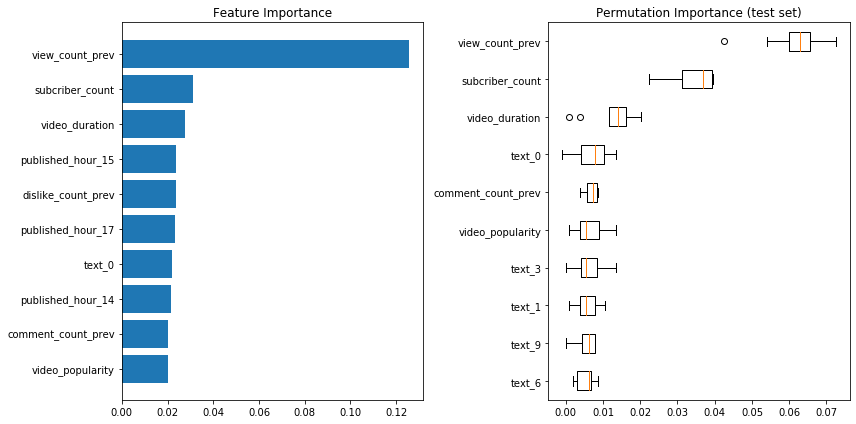

In [150]:
clf.fit(train_boost, train_target.ravel())
feature_importance = clf.feature_importances_
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos, np.array(columns)[sorted_idx][-10:])
plt.title('Feature Importance')

result = permutation_importance(clf, val_boost, val_target, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
xgboost_metrics = xgboost_metrics.sort_values(by=['roc_auc_test'], ascending = False)
xgboost_metrics.to_excel("xgboost_metrics_num_categ_text.xlsx", index=False)

In [71]:
pip install openpyxl

     |████████████████████████████████| 172 kB 5.5 MB/s eta 0:00:01
  Created wheel for openpyxl: filename=openpyxl-3.0.3-py2.py3-none-any.whl size=241262 sha256=cca0ecb83bf0d1954e6a20b03c83ab2815bb57d5d93f54c8206b604f86bc6473
  Stored in directory: /home/ilshaf1/.cache/pip/wheels/5b/c0/e7/e16d3916984addf40bd021fa98d1624cb24a9adc48da4e62b5
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8915 sha256=9b2aa10699ab040bc47af77173dffa1e87e67892804d477d7222493779970907
  Stored in directory: /home/ilshaf1/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built openpyxl et-xmlfile
Note: you may need to restart the kernel to use updated packages.


In [ ]:
dataset['pop_score'] = preds

In [ ]:
dataset.to_csv('dataset.csv', index=False)